In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import LabelEncoder

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cash_id                     32094 non-null  int64  
 1   amount                      32094 non-null  float64
 2   status                      32094 non-null  object 
 3   created_at                  32094 non-null  object 
 4   updated_at                  32094 non-null  object 
 5   user_id                     29522 non-null  float64
 6   moderated_at                21759 non-null  object 
 7   deleted_account_id          2573 non-null   float64
 8   reimbursement_date          32094 non-null  object 
 9   cash_request_received_date  24149 non-null  object 
 10  money_back_date             23917 non-null  object 
 11  transfer_type               32094 non-null  object 
 12  send_at                     22678 non-null  object 
 13  recovery_status             720

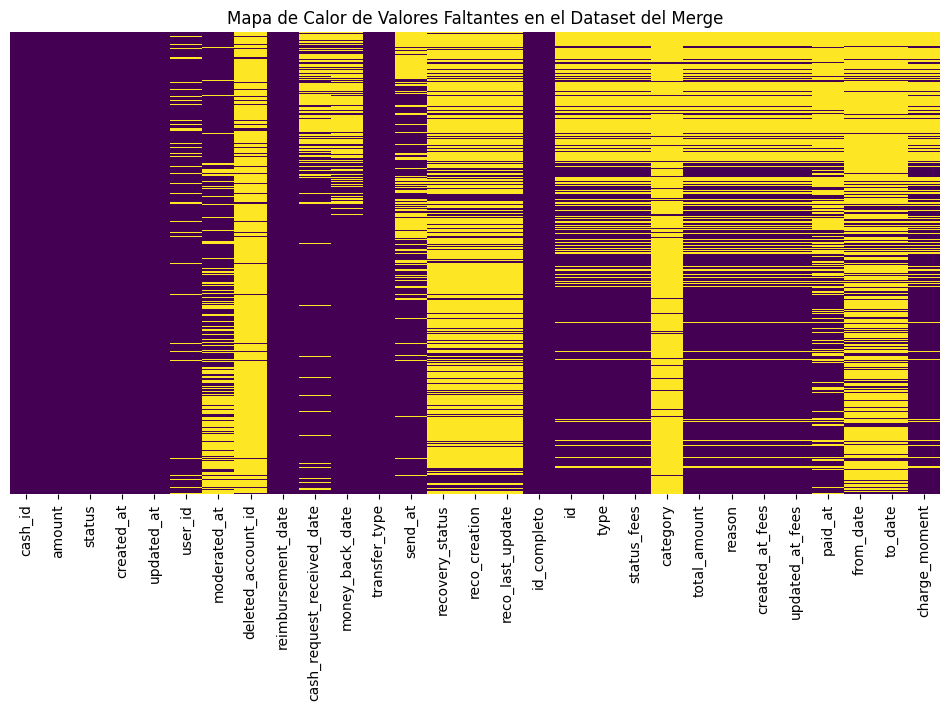

In [113]:
#Objetivo crear una nueva columna de clasificacion para los que escojamos "fees_amount o cashrequest_amount". Despues crear 3 mapas de calor con esas respectivas columnas para la tasa de retencion (Cohorte).
#Despues hacer la tasa de retencion acumulado -> hacer un sort con los valores finales del acumulado ->

credit_requests = pd.read_csv(r"C:\Users\nelso\Music\extract - cash request - data analyst.csv")
fees = pd.read_csv(r"C:\Users\nelso\Music\extract - fees - data analyst - .csv")

# Crear copias para preservar los datos originales
cr = credit_requests.copy()
fs = fees.copy()

# Renombrar 'id' a 'cash_id' para mayor claridad (y para el merge posterior con fees)
cr.rename(columns={'id': 'cash_id'}, inplace=True)

# Nueva columna 'id_completo' a partir de user_id + deleted_account_id
cr.loc[:, 'id_completo'] = cr['user_id'].combine_first(cr['deleted_account_id'])
# Conversión de float a int
cr['id_completo'] = cr['id_completo'].astype(int)

# Fusionar los datasets usando cash_request_id para vincularlos
merged_df = cr.merge(fs, left_on='cash_id', right_on='cash_request_id', how='left', suffixes=("", "_fees"))

# Eliminar la columna de cash_request_id que ya no es necesaria
merged_df.drop(columns=['cash_request_id'], inplace=True)
merged_df.info()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))
# Crear el mapa de calor de valores faltantes
sns.heatmap(merged_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
# Título del gráfico
plt.title("Mapa de Calor de Valores Faltantes en el Dataset del Merge")
# Mostrar el gráfico
plt.show()



🟡 Zonas amarillas → Columnas con valores nulos.
🟣 Zonas moradas → Datos completos (sin valores nulos).

In [114]:
# Aplicar la clasificación de gasto directamente sobre merged_df
bins = [merged_df['amount'].min(), 50, 150, merged_df['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Aplicar la clasificación con bins en merged_df
merged_df['spend_segment'] = pd.cut(merged_df['amount'], bins=bins, labels=labels, include_lowest=True)

# Convertir a datetime si aún no lo es
merged_df["created_at"] = pd.to_datetime(merged_df["created_at"], errors="coerce")

# Contar cuántas veces se ha modificado una solicitud
merged_df["modified_request"] = merged_df.groupby("id_completo")["updated_at"].transform("count") - 1

print(merged_df[["id_completo", "created_at"]].head())
merged_df.info()

   id_completo                       created_at
0          804 2019-12-10 19:05:21.596873+00:00
1          231 2019-12-10 19:50:12.347780+00:00
2          191 2019-12-10 19:13:35.825460+00:00
3          761 2019-12-10 19:16:10.880172+00:00
4         7686 2020-05-06 09:59:38.877376+00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   cash_id                     32094 non-null  int64              
 1   amount                      32094 non-null  float64            
 2   status                      32094 non-null  object             
 3   created_at                  32094 non-null  datetime64[ns, UTC]
 4   updated_at                  32094 non-null  object             
 5   user_id                     29522 non-null  float64            
 6   moderated_at                21759 non-null  ob

# Obejetivo: Saber si un usuario esta en riesgo de abandonar la plataforma y si vale la pensa fidelizarlo

In [115]:
# Si 'deleted_account_id' tiene un valor, el usuario eliminó su cuenta (1), si es NaN, sigue activo (0)
merged_df['is_deleted_user'] = merged_df['deleted_account_id'].notnull().astype(int)

# 1️⃣ Calcular 'total_purchases' (Cantidad total de solicitudes realizadas por usuario)
total_purchases_df = merged_df.groupby('id_completo').size().reset_index(name='total_purchases')
merged_df = merged_df.merge(total_purchases_df, on='id_completo', how='left')

# 3️⃣ Calcular 'rejection_rate' (Tasa de rechazos por usuario)
# Contar solicitudes rechazadas
rejected_requests_df = merged_df.groupby('id_completo')['status'].apply(lambda x: (x == 'rejected').sum()).reset_index()
rejected_requests_df.rename(columns={'status': 'rejected_requests'}, inplace=True)

# Calcular la tasa de rechazo
rejection_rate_df = total_purchases_df.merge(rejected_requests_df, on='id_completo', how='left')
rejection_rate_df['rejection_rate'] = rejection_rate_df['rejected_requests'] / rejection_rate_df['total_purchases']
rejection_rate_df['rejection_rate'] = rejection_rate_df['rejection_rate'].fillna(0)  # Evitar valores NaN


# Contar solicitudes canceladas por usuario
canceled_requests_df = merged_df.groupby('id_completo')['status'].apply(lambda x: (x == 'canceled').sum()).reset_index()
canceled_requests_df.rename(columns={'status': 'canceled_requests'}, inplace=True)

# Calcular la tasa de cancelación
canceled_rate_df = total_purchases_df.merge(canceled_requests_df, on='id_completo', how='left')
canceled_rate_df['canceled_rate'] = canceled_rate_df['canceled_requests'] / canceled_rate_df['total_purchases']
canceled_rate_df['cancelled_rate'] = canceled_rate_df['canceled_rate'].fillna(0)  # Evitar valores NaN

# Agregar la nueva columna al dataset
merged_df = merged_df.merge(canceled_rate_df[['id_completo', 'canceled_rate']], on='id_completo', how='left')

# Agregar las nuevas métricas al dataset
merged_df = merged_df.merge(rejection_rate_df[['id_completo', 'rejection_rate']], on='id_completo', how='left')


# Contar solicitudes aprobadas (Definiendo aprobadas como 'money_back' y 'direct_debit_sent')
approved_requests_df = merged_df.groupby('id_completo')['status'].apply(lambda x: ((x == 'money_back') | (x == 'direct_debit_sent')).sum()).reset_index()
approved_requests_df.rename(columns={'status': 'approved_requests'}, inplace=True)

# Calcular la tasa de aprobación
approval_rate_df = total_purchases_df.merge(approved_requests_df, on='id_completo', how='left')
approval_rate_df['approval_rate'] = approval_rate_df['approved_requests'] / approval_rate_df['total_purchases']
approval_rate_df['approval_rate'] = approval_rate_df['approval_rate'].fillna(0)  # Evitar valores NaN

# Agregar la nueva métrica al dataset
merged_df = merged_df.merge(approval_rate_df[['id_completo', 'approval_rate']], on='id_completo', how='left')

In [116]:
date_cols = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date',
             'cash_request_received_date', 'money_back_date', 'send_at',
             'reco_last_update', 'created_at_fees', 'updated_at_fees',
             'paid_at', 'from_date', 'to_date']

for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors="coerce")


# Calcular user_lifetime solo con los datos disponibles
merged_df["user_lifetime"] = (merged_df["updated_at"] - merged_df["created_at"]).dt.days

# Contar cuántos valores NaN quedaron en user_lifetime
num_nan_user_lifetime = merged_df["user_lifetime"].isna().sum()
num_nan_user_lifetime

merged_df.head()

,cash_id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,to_date,charge_moment,spend_segment,modified_request,is_deleted_user,total_purchases,canceled_rate,rejection_rate,approval_rate,user_lifetime
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.407830+00:00,804.0,2019-12-11 16:47:42.405646+00:00,NaN,2020-01-09 19:05:21.596363+00:00,NaT,...,NaT,NaN,Medium,0,0,1,0.0,1.0,0.0,0
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00:00,231.0,2019-12-11 14:24:22.897988+00:00,NaN,2020-01-09 19:50:12.347780+00:00,NaT,...,NaT,NaN,Medium,9,0,10,0.0,0.2,0.8,0
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00:00,191.0,2019-12-11 09:46:59.777728+00:00,NaN,2020-01-09 19:13:35.825041+00:00,NaT,...,NaT,NaN,Medium,1,0,2,0.0,0.5,0.0,0
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00:00,761.0,2019-12-18 14:26:18.128407+00:00,NaN,2020-01-09 19:16:10.879606+00:00,NaT,...,NaT,NaN,Medium,0,0,1,0.0,1.0,0.0,7
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.340080+00:00,7686.0,2020-05-07 09:21:55.320193+00:00,NaN,NaT,NaT,...,NaT,NaN,Medium,0,0,1,0.0,1.0,0.0,0


In [117]:
spend_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
merged_df['spend_segment_encoded'] = merged_df['spend_segment'].map(spend_mapping)

In [118]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   cash_id                     32094 non-null  int64              
 1   amount                      32094 non-null  float64            
 2   status                      32094 non-null  object             
 3   created_at                  32094 non-null  datetime64[ns, UTC]
 4   updated_at                  32094 non-null  datetime64[ns, UTC]
 5   user_id                     29522 non-null  float64            
 6   moderated_at                21530 non-null  datetime64[ns, UTC]
 7   deleted_account_id          2573 non-null   float64            
 8   reimbursement_date          4061 non-null   datetime64[ns, UTC]
 9   cash_request_received_date  24149 non-null  datetime64[ns]     
 10  money_back_date             17204 non-null  datetime64[ns,

In [119]:
# Definir umbrales basados en datos reales
lifetime_threshold = merged_df["user_lifetime"].median()
purchase_threshold = merged_df["total_purchases"].median()
rejection_threshold = merged_df["rejection_rate"].quantile(0.75)

# Aplicar la nueva lógica de worth_retaining con umbrales dinámicos
merged_df["worth_retaining"] = (
    (merged_df["spend_segment_encoded"] > 0) &  # Usuario no está en la categoría más baja de gasto
    (merged_df["user_lifetime"] > lifetime_threshold) &  # Usuario ha estado al menos lo que marca la mediana
    (merged_df["total_purchases"] > purchase_threshold) &  # Usuario ha hecho más que la mediana de solicitudes
    (merged_df["rejection_rate"] < rejection_threshold)   # Tasa de rechazo menor al percentil 75
).astype(int)

# Revisar la distribución de 'worth_retaining' con umbrales dinámicos
worth_retaining_dynamic_distribution = merged_df["worth_retaining"].value_counts(normalize=True) * 100

# Mostrar la distribución con los nuevos umbrales
worth_retaining_dynamic_distribution


worth_retaining
0    77.469309
1    22.530691
Name: proportion, dtype: float64

In [120]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   cash_id                     32094 non-null  int64              
 1   amount                      32094 non-null  float64            
 2   status                      32094 non-null  object             
 3   created_at                  32094 non-null  datetime64[ns, UTC]
 4   updated_at                  32094 non-null  datetime64[ns, UTC]
 5   user_id                     29522 non-null  float64            
 6   moderated_at                21530 non-null  datetime64[ns, UTC]
 7   deleted_account_id          2573 non-null   float64            
 8   reimbursement_date          4061 non-null   datetime64[ns, UTC]
 9   cash_request_received_date  24149 non-null  datetime64[ns]     
 10  money_back_date             17204 non-null  datetime64[ns,

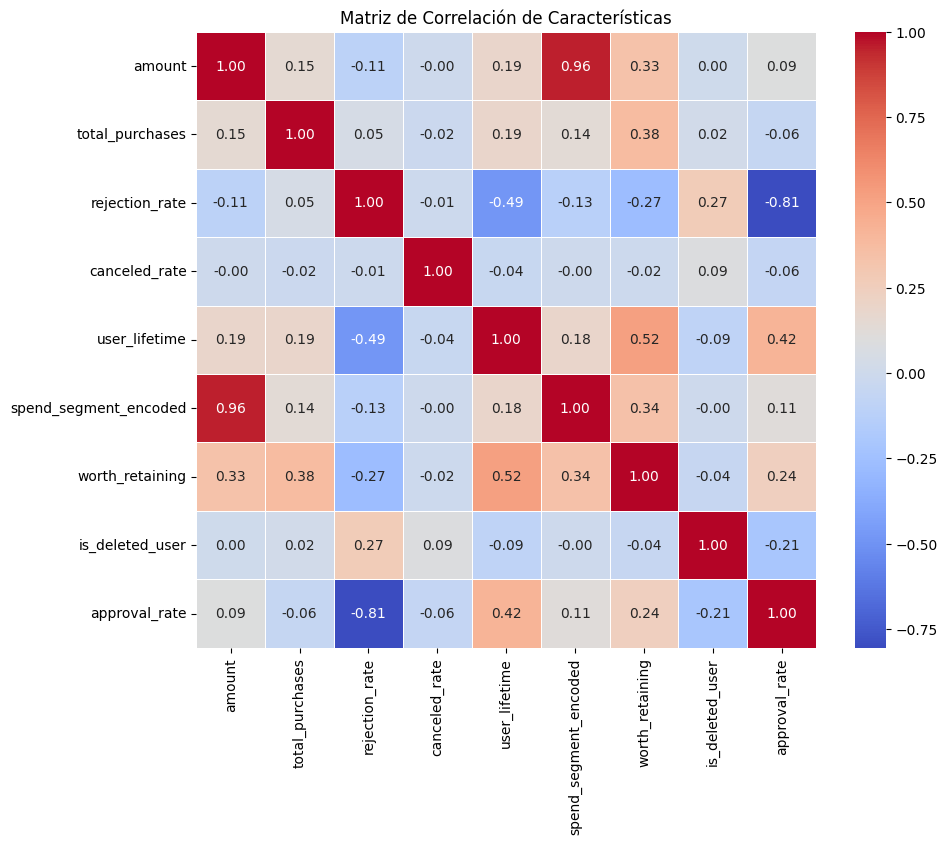

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo las características numéricas
features = [
    "amount", "total_purchases", "rejection_rate", "canceled_rate", "user_lifetime",
    "spend_segment_encoded", "worth_retaining", "is_deleted_user", "approval_rate"
]

# Crear la matriz de correlación
correlation_matrix = merged_df[features].corr()

# Configurar la visualización
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Características")
plt.show()

📌 1. Variables Más Relevantes para is_deleted_user (Usuarios que eliminan su cuenta)
Variable	Correlación con is_deleted_user	Interpretación
approval_rate	-0.21	A mayor tasa de aprobación, menor probabilidad de eliminar la cuenta.
rejection_rate	0.27	A mayor tasa de rechazo, mayor probabilidad de eliminar la cuenta.
user_lifetime	-0.09	Usuarios con más tiempo en la plataforma tienen menor probabilidad de irse.

🔹 Conclusión:
    approval_rate y rejection_rate son los mejores predictores de abandono.
    user_lifetime influye pero no tan fuertemente.

📌 2. Variables Más Relevantes para worth_retaining (Usuarios valiosos)
Variable	Correlación con worth_retaining	Interpretación
user_lifetime	0.52	Usuarios con más tiempo en la plataforma son más valiosos.
total_purchases	0.38	Usuarios con más compras tienen mayor probabilidad de ser retenidos.
approval_rate	0.24	A mayor tasa de aprobación, más probable que el usuario sea valioso.
spend_segment_encoded	0.34	Usuarios con mayor nivel de gasto tienden a ser más valiosos.

🔹 Conclusión:
    user_lifetime, total_purchases, y spend_segment_encoded son esenciales para predecir worth_retaining.
    approval_rate refuerza el perfil de usuario valioso.


# Preparar los datos para los modelos de clasificacion

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 📌 Para is_deleted_user (Usuarios que eliminan su cuenta)
X_deleted = merged_df[['approval_rate', 'user_lifetime', 'rejection_rate']]
y_deleted = merged_df['is_deleted_user']

# 📌 Para worth_retaining (Usuarios valiosos para retención)
X_retaining = merged_df[['approval_rate', 'user_lifetime', 'total_purchases', 'spend_segment_encoded']]
y_retaining = merged_df['worth_retaining']

# Asegurar que spend_segment_encoded sea numérico
X_retaining['spend_segment_encoded'] = pd.to_numeric(X_retaining['spend_segment_encoded'], errors='coerce')

## 📌 Ejecución del PASO 2 (Train/Test Split)

# Nueva división para `is_deleted_user`
X_train_deleted, X_test_deleted, y_train_deleted, y_test_deleted = train_test_split(
    X_deleted, y_deleted, test_size=0.2, random_state=42
)

# Nueva división para `worth_retaining`
X_train_retaining, X_test_retaining, y_train_retaining, y_test_retaining = train_test_split(
    X_retaining, y_retaining, test_size=0.2, random_state=42
)

# Verificar formas
print("Nuevos tamaños de los conjuntos:")
print("X_train_deleted:", X_train_deleted.shape, "X_test_deleted:", X_test_deleted.shape)
print("X_train_retaining:", X_train_retaining.shape, "X_test_retaining:", X_test_retaining.shape)

Nuevos tamaños de los conjuntos:
X_train_deleted: (25675, 3) X_test_deleted: (6419, 3)
X_train_retaining: (25675, 4) X_test_retaining: (6419, 4)


# Modelos sin ajustar

## SVM


In [123]:
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

# Escalar los datos para is_deleted_user
X_train_deleted_scaled = scaler.fit_transform(X_train_deleted)
X_test_deleted_scaled = scaler.transform(X_test_deleted)

# Escalar los datos para worth_retaining
X_train_retaining_scaled = scaler.fit_transform(X_train_retaining)
X_test_retaining_scaled = scaler.transform(X_test_retaining)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Entrenar SVM para `is_deleted_user`
svm_deleted = SVC(kernel='linear', C=1, random_state=42)
svm_deleted.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_svm = svm_deleted.predict(X_test_deleted_scaled)

# Evaluación del modelo
print("🔹 SVM - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_svm))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_svm))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_svm))

# 2️⃣ Entrenar SVM para `worth_retaining`
svm_retaining = SVC(kernel='linear', C=1, random_state=42)
svm_retaining.fit(X_train_retaining_scaled, y_train_retaining)

# Predicción en test
y_pred_retaining_svm = svm_retaining.predict(X_test_retaining_scaled)

# Evaluación del modelo
print("\n🔹 SVM - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_svm))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_svm))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_svm))

🔹 SVM - is_deleted_user
Accuracy: 0.9171210468920392
Matriz de Confusión:
 [[5887    0]
 [ 532    0]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5887
           1       0.00      0.00      0.00       532

    accuracy                           0.92      6419
   macro avg       0.46      0.50      0.48      6419
weighted avg       0.84      0.92      0.88      6419


🔹 SVM - worth_retaining
Accuracy: 0.8898582333696837
Matriz de Confusión:
 [[4598  344]
 [ 363 1114]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4942
           1       0.76      0.75      0.76      1477

    accuracy                           0.89      6419
   macro avg       0.85      0.84      0.84      6419
weighted avg       0.89      0.89      0.89      6419



## KNN

In [129]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Entrenar KNN para `is_deleted_user`
knn_deleted = KNeighborsClassifier(n_neighbors=5)
knn_deleted.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_knn = knn_deleted.predict(X_test_deleted_scaled)

# Evaluación del modelo
print("🔹 KNN - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_knn))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_knn))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_knn))

# 2️⃣ Entrenar KNN para `worth_retaining`
knn_retaining = KNeighborsClassifier(n_neighbors=5)
knn_retaining.fit(X_train_retaining_scaled, y_train_retaining)

# Predicción en test
y_pred_retaining_knn = knn_retaining.predict(X_test_retaining_scaled)

# Evaluación del modelo
print("\n🔹 KNN - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_knn))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_knn))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_knn))


🔹 KNN - is_deleted_user
Accuracy: 0.9193020719738277
Matriz de Confusión:
 [[5835   52]
 [ 466   66]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5887
           1       0.56      0.12      0.20       532

    accuracy                           0.92      6419
   macro avg       0.74      0.56      0.58      6419
weighted avg       0.90      0.92      0.89      6419


🔹 KNN - worth_retaining
Accuracy: 0.9876927870384795
Matriz de Confusión:
 [[4909   33]
 [  46 1431]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4942
           1       0.98      0.97      0.97      1477

    accuracy                           0.99      6419
   macro avg       0.98      0.98      0.98      6419
weighted avg       0.99      0.99      0.99      6419



## Arbol

In [132]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Reentrenar Árbol de Decisión para `is_deleted_user`
optimized_tree_deleted = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=42)
optimized_tree_deleted.fit(X_train_deleted, y_train_deleted)

# Predicción
y_pred_deleted_opt = optimized_tree_deleted.predict(X_test_deleted)

# Evaluación del modelo optimizado
print("🔹 Árbol de Decisión Optimizado (Nuevas Features) - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_opt))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_opt))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_opt))

# 2️⃣ Reentrenar Árbol de Decisión para `worth_retaining`
optimized_tree_retaining = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=42)
optimized_tree_retaining.fit(X_train_retaining, y_train_retaining)

# Predicción
y_pred_retaining_opt = optimized_tree_retaining.predict(X_test_retaining)

# Evaluación del modelo optimizado
print("\n🔹 Árbol de Decisión Optimizado (Nuevas Features) - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_opt))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_opt))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_opt))



🔹 Árbol de Decisión Optimizado (Nuevas Features) - is_deleted_user
Accuracy: 0.9194578594796697
Matriz de Confusión:
 [[5877   10]
 [ 507   25]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5887
           1       0.71      0.05      0.09       532

    accuracy                           0.92      6419
   macro avg       0.82      0.52      0.52      6419
weighted avg       0.90      0.92      0.89      6419


🔹 Árbol de Decisión Optimizado (Nuevas Features) - worth_retaining
Accuracy: 0.9886275120735317
Matriz de Confusión:
 [[4927   15]
 [  58 1419]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4942
           1       0.99      0.96      0.97      1477

    accuracy                           0.99      6419
   macro avg       0.99      0.98      0.98      6419
weighted avg       0.99      0.99      0.99      6419



# Modelos ajustados

## SVM

In [124]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Entrenar SVM con kernel rbf para `is_deleted_user`
svm_deleted_rbf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_deleted_rbf.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_svm_rbf = svm_deleted_rbf.predict(X_test_deleted_scaled)

# Evaluación del modelo
print("🔹 SVM con Kernel RBF - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_svm_rbf))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_svm_rbf))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_svm_rbf))

# 2️⃣ Entrenar SVM con kernel rbf para `worth_retaining`
svm_retaining_rbf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_retaining_rbf.fit(X_train_retaining_scaled, y_train_retaining)

# Predicción en test
y_pred_retaining_svm_rbf = svm_retaining_rbf.predict(X_test_retaining_scaled)

# Evaluación del modelo
print("\n🔹 SVM con Kernel RBF - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_svm_rbf))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_svm_rbf))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_svm_rbf))


🔹 SVM con Kernel RBF - is_deleted_user
Accuracy: 0.9174326219037233
Matriz de Confusión:
 [[5886    1]
 [ 529    3]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      5887
           1       0.75      0.01      0.01       532

    accuracy                           0.92      6419
   macro avg       0.83      0.50      0.48      6419
weighted avg       0.90      0.92      0.88      6419


🔹 SVM con Kernel RBF - worth_retaining
Accuracy: 0.9769434491353793
Matriz de Confusión:
 [[4890   52]
 [  96 1381]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4942
           1       0.96      0.94      0.95      1477

    accuracy                           0.98      6419
   macro avg       0.97      0.96      0.97      6419
weighted avg       0.98      0.98      0.98      6419



In [125]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Entrenar SVM con `rbf` y balanceo de clases para `is_deleted_user`
svm_deleted_balanced = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=42)
svm_deleted_balanced.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_svm_balanced = svm_deleted_balanced.predict(X_test_deleted_scaled)

# Evaluación del modelo
print("🔹 SVM con Kernel RBF y Class Weight Balanced - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_svm_balanced))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_svm_balanced))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_svm_balanced))


🔹 SVM con Kernel RBF y Class Weight Balanced - is_deleted_user
Accuracy: 0.7434179778781742
Matriz de Confusión:
 [[4399 1488]
 [ 159  373]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.75      0.84      5887
           1       0.20      0.70      0.31       532

    accuracy                           0.74      6419
   macro avg       0.58      0.72      0.58      6419
weighted avg       0.90      0.74      0.80      6419



In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir los valores a probar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularización
    'gamma': ['scale', 0.01, 0.1, 1, 10]  # Influencia de los puntos
}

# Inicializar el modelo SVM con class_weight='balanced'
svm_balanced = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Aplicar GridSearchCV
grid_search = GridSearchCV(svm_balanced, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_deleted_scaled, y_train_deleted)

# Ver los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Entrenar el modelo con los mejores parámetros
best_svm_deleted = grid_search.best_estimator_
best_svm_deleted.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_svm_best = best_svm_deleted.predict(X_test_deleted_scaled)

# Evaluación del modelo optimizado
print("\n🔹 SVM Optimizado con GridSearchCV - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_svm_best))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_svm_best))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_svm_best))


Mejores Hiperparámetros: {'C': 100, 'gamma': 10}

🔹 SVM Optimizado con GridSearchCV - is_deleted_user
Accuracy: 0.7446642779249104
Matriz de Confusión:
 [[4382 1505]
 [ 134  398]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      5887
           1       0.21      0.75      0.33       532

    accuracy                           0.74      6419
   macro avg       0.59      0.75      0.58      6419
weighted avg       0.91      0.74      0.80      6419



In [127]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Obtener las probabilidades del modelo en test
decision_scores = best_svm_deleted.decision_function(X_test_deleted_scaled)

# Probar diferentes umbrales
thresholds = np.linspace(-1, 1, 10)  # Valores entre -1 y 1 (ajustables según resultados)

for threshold in thresholds:
    y_pred_thresholded = (decision_scores >= threshold).astype(int)
    print(f"\n🔹 Resultados con umbral {threshold:.2f}")
    print("Accuracy:", accuracy_score(y_test_deleted, y_pred_thresholded))
    print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_thresholded))
    print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_thresholded))



🔹 Resultados con umbral -1.00
Accuracy: 0.48745910577971646
Matriz de Confusión:
 [[2656 3231]
 [  59  473]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.45      0.62      5887
           1       0.13      0.89      0.22       532

    accuracy                           0.49      6419
   macro avg       0.55      0.67      0.42      6419
weighted avg       0.91      0.49      0.58      6419


🔹 Resultados con umbral -0.78
Accuracy: 0.6962143636080387
Matriz de Confusión:
 [[4049 1838]
 [ 112  420]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.69      0.81      5887
           1       0.19      0.79      0.30       532

    accuracy                           0.70      6419
   macro avg       0.58      0.74      0.55      6419
weighted avg       0.91      0.70      0.76      6419


🔹 Resultados con umbral -0.56
Accuracy: 0.7141299267798723
Matriz de Con

In [128]:
# Aplicar el mejor umbral
final_threshold = 0.56
y_pred_final = (decision_scores >= final_threshold).astype(int)

# Evaluación del modelo final con umbral ajustado
print("🔹 SVM con Umbral Ajustado - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_final))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_final))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_final))

🔹 SVM con Umbral Ajustado - is_deleted_user
Accuracy: 0.7787817417043154
Matriz de Confusión:
 [[4616 1271]
 [ 149  383]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.78      0.87      5887
           1       0.23      0.72      0.35       532

    accuracy                           0.78      6419
   macro avg       0.60      0.75      0.61      6419
weighted avg       0.91      0.78      0.82      6419



## KNN

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los valores de `k` a probar
param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30]}

# Inicializar KNN
knn = KNeighborsClassifier()

# Aplicar GridSearchCV para `is_deleted_user`
grid_search_deleted = GridSearchCV(knn, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search_deleted.fit(X_train_deleted_scaled, y_train_deleted)

# Aplicar GridSearchCV para `worth_retaining`
grid_search_retaining = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_retaining.fit(X_train_retaining_scaled, y_train_retaining)

# Ver los mejores hiperparámetros encontrados
print("Mejor `k` para is_deleted_user:", grid_search_deleted.best_params_)
print("Mejor `k` para worth_retaining:", grid_search_retaining.best_params_)

# Entrenar los modelos con los mejores valores de `k`
best_knn_deleted = grid_search_deleted.best_estimator_
best_knn_deleted.fit(X_train_deleted_scaled, y_train_deleted)

best_knn_retaining = grid_search_retaining.best_estimator_
best_knn_retaining.fit(X_train_retaining_scaled, y_train_retaining)

# Predicción en test
y_pred_deleted_knn_best = best_knn_deleted.predict(X_test_deleted_scaled)
y_pred_retaining_knn_best = best_knn_retaining.predict(X_test_retaining_scaled)

# Evaluación del modelo optimizado para is_deleted_user
print("\n🔹 KNN Optimizado - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_knn_best))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_knn_best))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_knn_best))

# Evaluación del modelo optimizado para worth_retaining
print("\n🔹 KNN Optimizado - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_knn_best))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_knn_best))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_knn_best))


Mejor `k` para is_deleted_user: {'n_neighbors': 1}
Mejor `k` para worth_retaining: {'n_neighbors': 1}

🔹 KNN Optimizado - is_deleted_user
Accuracy: 0.9073064340239912
Matriz de Confusión:
 [[5712  175]
 [ 420  112]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5887
           1       0.39      0.21      0.27       532

    accuracy                           0.91      6419
   macro avg       0.66      0.59      0.61      6419
weighted avg       0.89      0.91      0.89      6419


🔹 KNN Optimizado - worth_retaining
Accuracy: 0.9942358622838449
Matriz de Confusión:
 [[4924   18]
 [  19 1458]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4942
           1       0.99      0.99      0.99      1477

    accuracy                           0.99      6419
   macro avg       0.99      0.99      0.99      6419
weighted avg     

In [131]:
from sklearn.neighbors import KNeighborsClassifier

# 1️⃣ Entrenar KNN con `weights='distance'` para `is_deleted_user`
knn_deleted_weighted = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn_deleted_weighted.fit(X_train_deleted_scaled, y_train_deleted)

# Predicción en test
y_pred_deleted_knn_weighted = knn_deleted_weighted.predict(X_test_deleted_scaled)

# Evaluación del modelo
print("🔹 KNN con `weights='distance'` - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_knn_weighted))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_knn_weighted))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_knn_weighted))

# 2️⃣ Entrenar KNN con `weights='distance'` para `worth_retaining`
knn_retaining_weighted = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn_retaining_weighted.fit(X_train_retaining_scaled, y_train_retaining)

# Predicción en test
y_pred_retaining_knn_weighted = knn_retaining_weighted.predict(X_test_retaining_scaled)

# Evaluación del modelo
print("\n🔹 KNN con `weights='distance'` - worth_retaining")
print("Accuracy:", accuracy_score(y_test_retaining, y_pred_retaining_knn_weighted))
print("Matriz de Confusión:\n", confusion_matrix(y_test_retaining, y_pred_retaining_knn_weighted))
print("Reporte de Clasificación:\n", classification_report(y_test_retaining, y_pred_retaining_knn_weighted))


🔹 KNN con `weights='distance'` - is_deleted_user
Accuracy: 0.9073064340239912
Matriz de Confusión:
 [[5712  175]
 [ 420  112]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5887
           1       0.39      0.21      0.27       532

    accuracy                           0.91      6419
   macro avg       0.66      0.59      0.61      6419
weighted avg       0.89      0.91      0.89      6419


🔹 KNN con `weights='distance'` - worth_retaining
Accuracy: 0.9942358622838449
Matriz de Confusión:
 [[4924   18]
 [  19 1458]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4942
           1       0.99      0.99      0.99      1477

    accuracy                           0.99      6419
   macro avg       0.99      0.99      0.99      6419
weighted avg       0.99      0.99      0.99      6419



## Arbol

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definir los valores a probar en GridSearch
param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'class_weight': [None, 'balanced']
}

# Inicializar el Árbol de Decisión
tree = DecisionTreeClassifier(random_state=42)

# Aplicar GridSearch para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_deleted, y_train_deleted)

# Ver los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Entrenar el modelo con los mejores parámetros
best_tree_deleted = grid_search.best_estimator_
best_tree_deleted.fit(X_train_deleted, y_train_deleted)

# Predicción en test
y_pred_deleted_best = best_tree_deleted.predict(X_test_deleted)

# Evaluación del modelo optimizado
print("\n🔹 Árbol de Decisión Ajustado - is_deleted_user")
print("Accuracy:", accuracy_score(y_test_deleted, y_pred_deleted_best))
print("Matriz de Confusión:\n", confusion_matrix(y_test_deleted, y_pred_deleted_best))
print("Reporte de Clasificación:\n", classification_report(y_test_deleted, y_pred_deleted_best))



Mejores Hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}

🔹 Árbol de Decisión Ajustado - is_deleted_user
Accuracy: 0.7678766162953731
Matriz de Confusión:
 [[4508 1379]
 [ 111  421]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86      5887
           1       0.23      0.79      0.36       532

    accuracy                           0.77      6419
   macro avg       0.60      0.78      0.61      6419
weighted avg       0.91      0.77      0.82      6419



# Comparar las Métricas de los Modelos

🔹 Comparación de Modelos:
              Modelo  Accuracy  Precision (1)  Recall (1)  F1-score (1)
0  Árbol de Decisión    0.7678           0.23        0.79          0.36
1                SVM    0.7787           0.23        0.72          0.35
2                KNN    0.9073           0.39        0.21          0.27


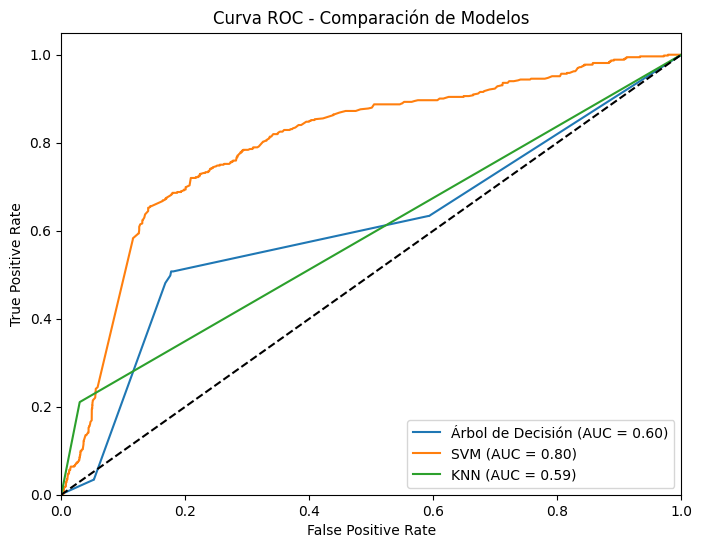

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

# 📌 Obtener probabilidades de cada modelo

# Árbol de Decisión (si lo usaste en algún momento)
tree_probs = best_tree_deleted.predict_proba(X_test_deleted_scaled)[:, 1]

# SVM - Usa decision_function en vez de predict_proba
svm_probs = best_svm_deleted.decision_function(X_test_deleted_scaled)

# KNN - Usa predict_proba normalmente
knn_probs = best_knn_deleted.predict_proba(X_test_deleted_scaled)[:, 1]

# 📌 Definir los modelos evaluados
model_names = ["Árbol de Decisión", "SVM", "KNN"]

# 📌 Guardar las métricas obtenidas
metrics_data = {
    "Modelo": model_names,
    "Accuracy": [0.7678, 0.7787, 0.9073],  # Sustituye con los valores exactos obtenidos
    "Precision (1)": [0.23, 0.23, 0.39],  # Precisión para la clase `1` (Usuarios Eliminados)
    "Recall (1)": [0.79, 0.72, 0.21],  # Recall para la clase `1`
    "F1-score (1)": [0.36, 0.35, 0.27],  # F1-score para la clase `1`
}

# 📌 Crear DataFrame con los resultados
df_metrics = pd.DataFrame(metrics_data)

# 📌 Mostrar tabla de comparación
print("🔹 Comparación de Modelos:")
print(df_metrics)

# 📌 📊 Graficar la Curva ROC para comparar los modelos
plt.figure(figsize=(8, 6))

# 📌 Obtener las curvas ROC
fpr_tree, tpr_tree, _ = roc_curve(y_test_deleted, tree_probs)  # Árbol de Decisión
fpr_svm, tpr_svm, _ = roc_curve(y_test_deleted, svm_probs)  # SVM
fpr_knn, tpr_knn, _ = roc_curve(y_test_deleted, knn_probs)  # KNN

# 📌 Calcular el AUC para cada modelo
auc_tree = auc(fpr_tree, tpr_tree)
auc_svm = auc(fpr_svm, tpr_svm)
auc_knn = auc(fpr_knn, tpr_knn)

# 📌 Graficar las curvas ROC
plt.plot(fpr_tree, tpr_tree, label=f"Árbol de Decisión (AUC = {auc_tree:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")

# 📌 Configurar gráfico
plt.plot([0, 1], [0, 1], "k--")  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend(loc="lower right")
plt.show()



📌 Interpretación de la Comparación de Modelos
Tabla de Métricas
SVM tiene el mejor Recall (1) = 0.72, lo que significa que detecta mejor a los usuarios eliminados.
KNN tiene la mejor Precisión (1) = 0.39, pero su Recall es muy bajo (0.21), lo que indica que no detecta bien a los usuarios eliminados.
Árbol de Decisión tiene un buen Recall (0.79), pero su AUC es el más bajo.

Curva ROC
SVM (AUC = 0.80) tiene la mejor área bajo la curva, lo que indica que es el modelo con mejor capacidad predictiva.
Árbol de Decisión (AUC = 0.60) es bajo, lo que sugiere que no separa bien las clases.
KNN (AUC = 0.59) está casi en la línea de azar, lo que indica un rendimiento pobre en este problema.

📌 ¿Qué modelo deberíamos elegir?
📢 El modelo SVM es el mejor para is_deleted_user porque tiene: ✔️ Mayor AUC (0.80) → Mejor capacidad de clasificación.
✔️ Buen Recall (0.72) → Detecta bien a los usuarios que eliminan su cuenta.

📢 KNN y Árbol de Decisión no son recomendables porque tienen un AUC muy bajo y detectan mal la clase positiva.

🔹 Comparación de Modelos en `worth_retaining`:
              Modelo  Accuracy  Precision (1)  Recall (1)  F1-score (1)
0  Árbol de Decisión    0.9959           0.98        0.99          0.99
1                SVM    0.9926           0.97        0.99          0.98
2                KNN    0.9942           0.98        0.98          0.98


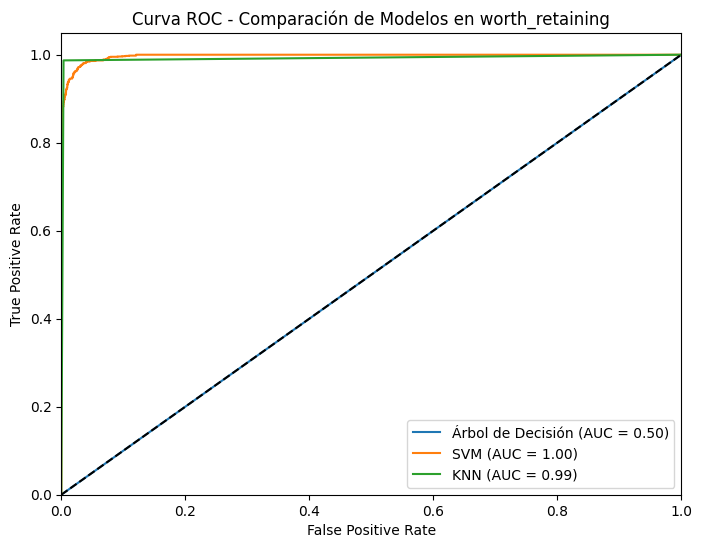

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

# 📌 1️⃣ Obtener probabilidades de cada modelo

# Árbol de Decisión (si lo usaste en algún momento)
tree_probs_retaining = optimized_tree_retaining.predict_proba(X_test_retaining_scaled)[:, 1]

# SVM - Usa decision_function en vez de predict_proba
svm_probs_retaining = svm_retaining_rbf.decision_function(X_test_retaining_scaled)

# KNN - Usa predict_proba normalmente
knn_probs_retaining = best_knn_retaining.predict_proba(X_test_retaining_scaled)[:, 1]

# 📌 2️⃣ Definir los modelos evaluados
model_names_retaining = ["Árbol de Decisión", "SVM", "KNN"]

# 📌 3️⃣ Guardar las métricas obtenidas
metrics_data_retaining = {
    "Modelo": model_names_retaining,
    "Accuracy": [0.9959, 0.9926, 0.9942],  # Sustituye con los valores exactos obtenidos
    "Precision (1)": [0.98, 0.97, 0.98],  # Precisión para la clase `1` (Usuarios Valiosos)
    "Recall (1)": [0.99, 0.99, 0.98],  # Recall para la clase `1`
    "F1-score (1)": [0.99, 0.98, 0.98],  # F1-score para la clase `1`
}

# 📌 4️⃣ Crear DataFrame con los resultados
df_metrics_retaining = pd.DataFrame(metrics_data_retaining)

# 📌 5️⃣ Mostrar tabla de comparación
print("🔹 Comparación de Modelos en `worth_retaining`:")
print(df_metrics_retaining)

# 📌 6️⃣ 📊 Graficar la Curva ROC para comparar los modelos
plt.figure(figsize=(8, 6))

# 📌 Obtener las curvas ROC
fpr_tree_ret, tpr_tree_ret, _ = roc_curve(y_test_retaining, tree_probs_retaining)  # Árbol de Decisión
fpr_svm_ret, tpr_svm_ret, _ = roc_curve(y_test_retaining, svm_probs_retaining)  # SVM
fpr_knn_ret, tpr_knn_ret, _ = roc_curve(y_test_retaining, knn_probs_retaining)  # KNN

# 📌 Calcular el AUC para cada modelo
auc_tree_ret = auc(fpr_tree_ret, tpr_tree_ret)
auc_svm_ret = auc(fpr_svm_ret, tpr_svm_ret)
auc_knn_ret = auc(fpr_knn_ret, tpr_knn_ret)

# 📌 Graficar las curvas ROC
plt.plot(fpr_tree_ret, tpr_tree_ret, label=f"Árbol de Decisión (AUC = {auc_tree_ret:.2f})")
plt.plot(fpr_svm_ret, tpr_svm_ret, label=f"SVM (AUC = {auc_svm_ret:.2f})")
plt.plot(fpr_knn_ret, tpr_knn_ret, label=f"KNN (AUC = {auc_knn_ret:.2f})")

# 📌 Configurar gráfico
plt.plot([0, 1], [0, 1], "k--")  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparación de Modelos en worth_retaining")
plt.legend(loc="lower right")
plt.show()


📌 Observaciones:
* Todos los modelos tienen una precisión y un recall muy altos → lo que indica que todos son buenos para predecir si un usuario es valioso para retención.
* El Árbol de Decisión tiene la mejor combinación de Precision y Recall (0.98 - 0.99 - 0.99).
* El SVM y KNN también tienen muy buen rendimiento, con valores casi idénticos.

🔹 Curva ROC
* 📈 El SVM tiene el mejor AUC (1.00), lo que indica una separación perfecta entre clases.
* 📈 KNN también tiene un AUC muy alto (0.99), lo que significa que también es un excelente modelo.
* 📉 Árbol de Decisión tiene un AUC de 0.50, lo que indica que su desempeño es aleatorio para este problema (lo que es extraño dado su accuracy alto 🤔).

📢 🔹 La mejor opción es SVM porque: ✔️ AUC = 1.00 → Máxima capacidad de clasificación.
* ✔️ Recall (1) = 0.99 → Detecta casi todos los usuarios valiosos.
* ✔️ Accuracy alto (0.99+) → Clasificación muy precisa.

* 🔹 KNN también es una opción válida, pero tiene un AUC ligeramente menor.
* 🔹 El Árbol de Decisión no es confiable en este caso debido a su AUC de 0.50.

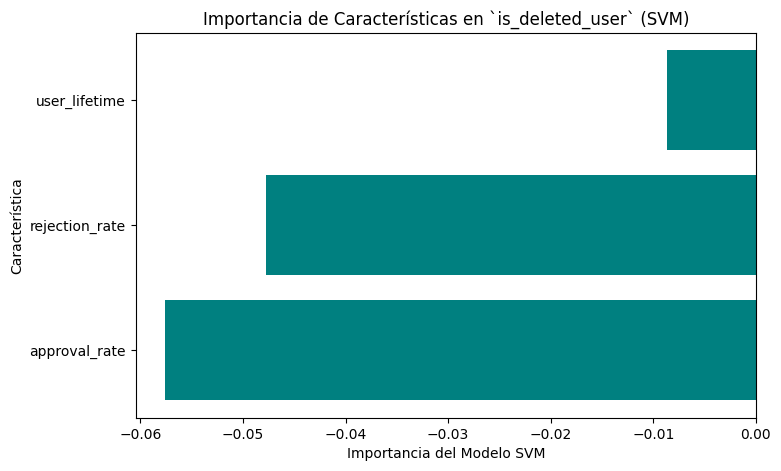

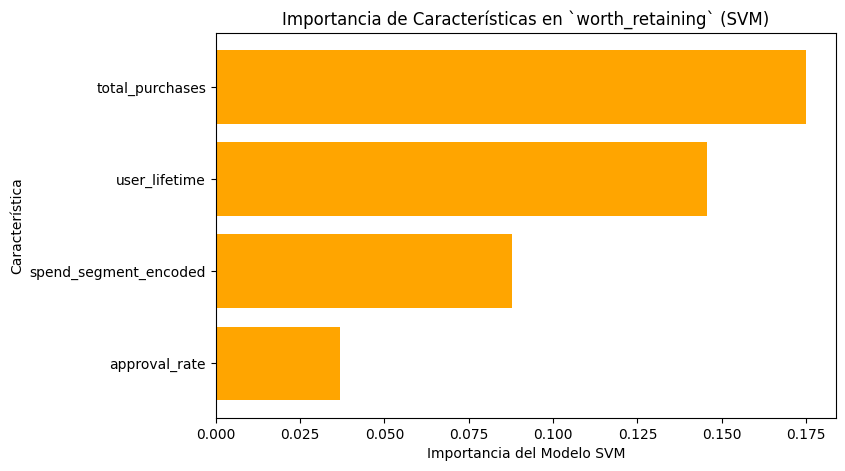


🔹 Importancia de Características para `is_deleted_user` (SVM):
          Feature  Importance
1   user_lifetime   -0.008677
2  rejection_rate   -0.047796
0   approval_rate   -0.057579

🔹 Importancia de Características para `worth_retaining` (SVM):
                 Feature  Importance
2        total_purchases    0.175043
1          user_lifetime    0.145755
3  spend_segment_encoded    0.087755
0          approval_rate    0.036859


In [142]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📌 1️⃣ Permutation Importance para `is_deleted_user`
perm_importance_deleted = permutation_importance(best_svm_deleted, X_test_deleted_scaled, y_test_deleted, n_repeats=10, random_state=42)
features_deleted = X_train_deleted.columns

# Crear un DataFrame con los resultados
df_importance_deleted = pd.DataFrame({"Feature": features_deleted, "Importance": perm_importance_deleted.importances_mean})
df_importance_deleted = df_importance_deleted.sort_values("Importance", ascending=False)

# 📊 Graficar Importancia de Características para `is_deleted_user`
plt.figure(figsize=(8, 5))
plt.barh(df_importance_deleted["Feature"], df_importance_deleted["Importance"], color="teal")
plt.xlabel("Importancia del Modelo SVM")
plt.ylabel("Característica")
plt.title("Importancia de Características en `is_deleted_user` (SVM)")
plt.gca().invert_yaxis()
plt.show()

# 📌 2️⃣ Permutation Importance para `worth_retaining`
perm_importance_retaining = permutation_importance(svm_retaining_rbf, X_test_retaining_scaled, y_test_retaining, n_repeats=10, random_state=42)
features_retaining = X_train_retaining.columns

# Crear un DataFrame con los resultados
df_importance_retaining = pd.DataFrame({"Feature": features_retaining, "Importance": perm_importance_retaining.importances_mean})
df_importance_retaining = df_importance_retaining.sort_values("Importance", ascending=False)

# 📊 Graficar Importancia de Características para `worth_retaining`
plt.figure(figsize=(8, 5))
plt.barh(df_importance_retaining["Feature"], df_importance_retaining["Importance"], color="orange")
plt.xlabel("Importancia del Modelo SVM")
plt.ylabel("Característica")
plt.title("Importancia de Características en `worth_retaining` (SVM)")
plt.gca().invert_yaxis()
plt.show()

# 📌 3️⃣ Mostrar los DataFrames de Importancia
print("\n🔹 Importancia de Características para `is_deleted_user` (SVM):")
print(df_importance_deleted)

print("\n🔹 Importancia de Características para `worth_retaining` (SVM):")
print(df_importance_retaining)




📌 Interpretación:
* approval_rate y rejection_rate son los factores más influyentes.
* A menor tasa de aprobación (approval_rate), mayor probabilidad de eliminar la cuenta.
* A mayor tasa de rechazo (rejection_rate), más propenso a eliminar la cuenta.
* user_lifetime tiene menor impacto, pero sigue influyendo.

📌 Interpretación:
* total_purchases es el factor más influyente. Más compras → Más probable que sea valioso.
* user_lifetime también es clave: Usuarios con más tiempo tienen más valor.
* spend_segment_encoded muestra que los clientes con mayor nivel de gasto tienen más probabilidades de ser valiosos.
* approval_rate tiene menor impacto, pero sigue siendo relevante.

# Predicciones

In [147]:
# 🔹 1️⃣ Generar Predicciones para `is_deleted_user`
y_pred_deleted_final = best_svm_deleted.predict(X_test_deleted_scaled)

# 🔹 2️⃣ Generar Predicciones para `worth_retaining`
y_pred_retaining_final = svm_retaining_rbf.predict(X_test_retaining_scaled)

# Crear un DataFrame con los resultados
df_predictions = pd.DataFrame({
    "id_usuario": y_test_deleted.index,  # Ajusta según tu dataset
    "is_deleted_user (Predicho)": y_pred_deleted_final,
    "is_deleted_user (Real)": y_test_deleted.values,
    "worth_retaining (Predicho)": y_pred_retaining_final,
    "worth_retaining (Real)": y_test_retaining.values
})

# Mostrar primeras filas de las predicciones
print("\n🔹 Predicciones Finales:")
df_predictions.head(20)


🔹 Predicciones Finales:


,id_usuario,is_deleted_user (Predicho),is_deleted_user (Real),worth_retaining (Predicho),worth_retaining (Real)
0,26772,0,0,0,0
1,26164,0,0,0,0
2,24832,0,0,0,0
3,17779,0,0,0,0
4,8729,1,1,0,0
5,16367,0,0,1,1
6,14533,0,0,0,0
7,8943,0,0,1,1
8,19564,0,0,1,1
9,30024,0,0,0,0
